<a href="https://colab.research.google.com/github/paras2001-hub/alzheimers-disease-severity/blob/main/Alzheimer's_Disease_Severity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alzheimer's Disease Classification

### Importing the necessary libraries

In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint

#Handling Files
import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
import cv2

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.listdir()

['.config', 'drive', 'dataset', 'sample_data']

### Data Pre-Processing

In [ ]:
base_dir = "/content/drive/MyDrive/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

In [ ]:
if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['VeryMildDemented', 'ModerateDemented', 'MildDemented', 'NonDemented']


In [ ]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 150
IMAGE_SIZE = [150, 150]
DIM = (IMG_SIZE, IMG_SIZE)

# Imbalance in Dataset

In [ ]:
num_samples = dict()

for folder in os.listdir(work_dir):
  if folder in CLASSES:
    num_samples[folder] = len(os.listdir(work_dir + folder))

In [ ]:
num_samples

{'VeryMildDemented': 2240,
 'ModerateDemented': 64,
 'MildDemented': 896,
 'NonDemented': 3200}

<BarContainer object of 4 artists>

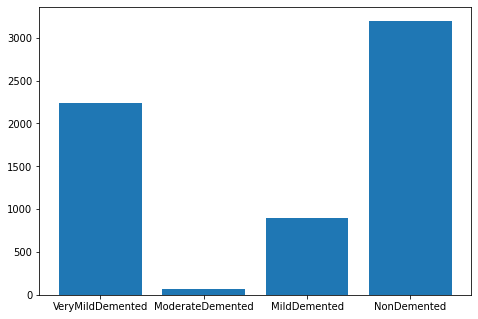

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(num_samples.keys(),num_samples.values())

It is observable that the number of data samples for 'ModerateDemented' and 'MildDemented' are less. \
Thus, we shall perform image augumention to balance the data samples.

In [ ]:
os.listdir(WORK_DIR)

['VeryMildDemented', 'ModerateDemented', 'MildDemented', 'NonDemented']

In [ ]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)
test_data_gen = work_dr.flow_from_directory(directory=test_dir, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


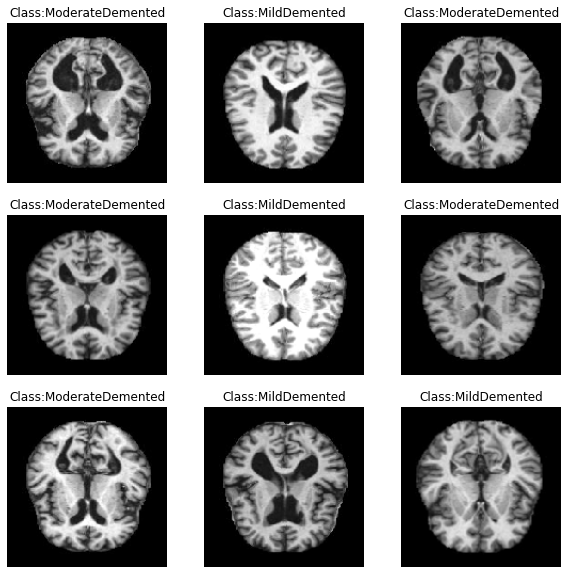

In [ ]:
def show_images(generator, y_pred=None):
    # get image lables
    labels = dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x, y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

Retrieving the data from the ImageDataGenerator iterator

In [ ]:
train_data_generated, train_labels_generated = train_data_gen.next()

Saving np-arrays as a precaution against kernel crashes.

In [ ]:
np.save(base_dir + "train_data_generated", train_data_generated)
np.save(base_dir + "train_labels", train_labels_generated)

In [ ]:
train_data_generated = np.load(base_dir + "train_data_generated.npy")

In [ ]:
train_labels = np.load(base_dir + "train_labels.npy")

Dimensions of the dataset

In [ ]:
print(train_data_generated.shape, train_labels.shape)

(6400, 150, 150, 3) (6400, 4)


# Data Reduction

As image data is complex, it becomes heavy for SMOTE to perform oversampling as well as for the models to converge. \
Thus, we employ different techniques to reduce dimensions keeping components to maintain 85% variance in data.

### Grayscaling all images

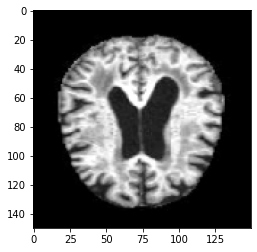

In [ ]:
plt.imshow(train_data_generated[5])

In [ ]:
train_data_generated[5][80][80]

array([0.08235294, 0.08235294, 0.08235294], dtype=float32)

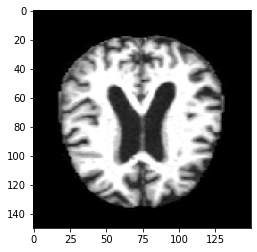

In [ ]:
plt.imshow(train_data_generated[0])

In [ ]:
image = np.copy(train_data_generated[0])
gray_scaled = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

for i in range(IMG_SIZE):
  for j in range(IMG_SIZE):
    for k in range(3):
      image[i][j][k] = gray_scaled[i][j] - image[i][j][k]

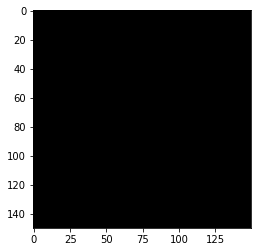

In [ ]:
plt.imshow(image)

Considering a random image as a sample, it can be observed that there is no difference between R, G & B values i.e. values are same. \
Thus, they present redundant information which can be eliminated by gray-scaling.

In [ ]:
def rgbToGrayScale(image_list):
  gray_scaled = []
  for image in image_list:
    gray_scaled.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
  return gray_scaled

In [ ]:
train_data_grayscaled = rgbToGrayScale(train_data_generated)

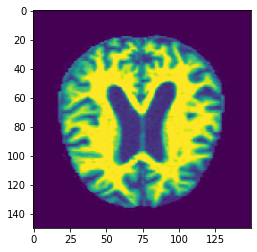

In [ ]:
plt.imshow(train_data_grayscaled[0])

In [ ]:
train_data_grayscaled[0][80][80]

0.14117648

In [ ]:
np.save(base_dir + "train_data_grayscaled", train_data_grayscaled)

In [ ]:
train_data_grayscaled = np.load(base_dir + "train_data_grayscaled.npy")

### Principal Component Analysis

In [ ]:
train_data_grayscaled.shape

(6400, 150, 150)

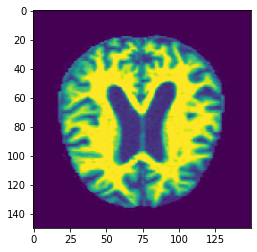

In [ ]:
plt.imshow(train_data_grayscaled[0])

In [ ]:
train_data_reshaped = train_data_grayscaled.reshape(len(train_data_grayscaled), IMG_SIZE * IMG_SIZE)
train_data_reshaped.shape

(6400, 22500)

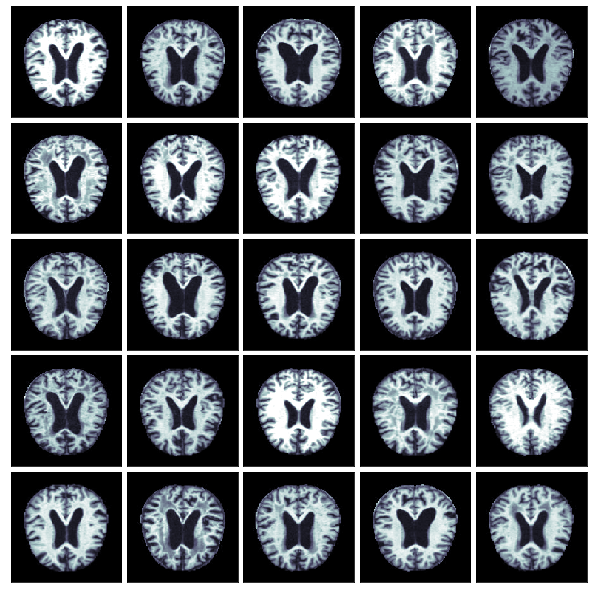

In [ ]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 

for i in range(25):
  ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[]) 
  ax.imshow(train_data_grayscaled[i], cmap=plt.cm.bone, interpolation='nearest')

plt.show()

Retain 90% of variance

In [ ]:
pca = PCA(n_components=0.9)

In [ ]:
reduced_train_data = pca.fit_transform(train_data_reshaped)

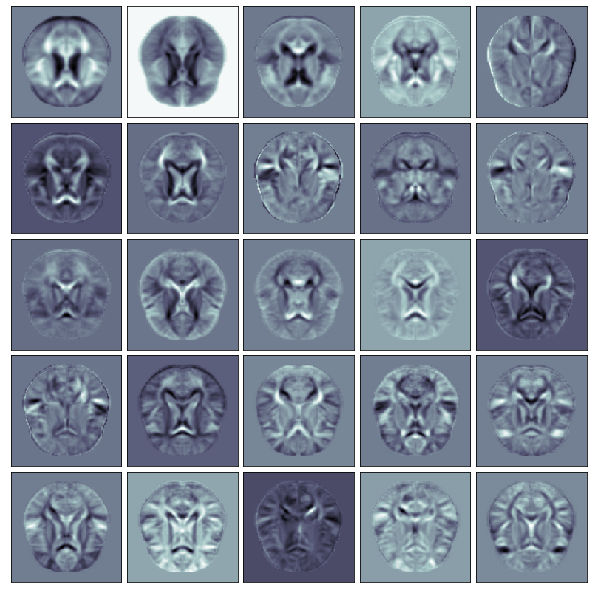

In [ ]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(25): 
  ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[]) 
  ax.imshow(np.reshape(pca.components_[i,:], (150,150)), cmap=plt.cm.bone, interpolation='nearest')

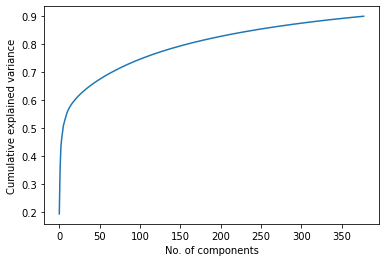

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('No. of components')
plt.ylabel('Cumulative explained variance');

In [ ]:
reduced_train_data.shape

(6400, 378)

In [ ]:
np.save(base_dir + "reduced_train_data", reduced_train_data)

In [ ]:
reduced_train_data = np.load(base_dir + "reduced_train_data.npy")
train_labels = np.load(base_dir  + "train_labels.npy")

# Image Augmentation

Increase the number of data samples

Performing over-sampling, since the classes are imbalanced

In [ ]:
sm = SMOTE(random_state=42, n_jobs=2, k_neighbors=4, sampling_strategy="auto")

train_data, train_labels = sm.fit_resample(reduced_train_data, train_labels)

print(train_data.shape, train_labels.shape)

(12800, 378) (12800, 4)


Saving np-arrays as a precaution against kernel crashes.

In [ ]:
np.save(base_dir + "train_data_oversampled", train_data)
np.save(base_dir + "train_labels_oversampled", train_labels)

In [ ]:
os.listdir("/content/drive/MyDrive/Alzheimer_s Dataset")

['train',
 'test',
 'train_data.npy',
 'train_labels.npy',
 'alzheimer_cnn_model',
 'train_labels_generated.npy',
 'alzheimer_cnn_model_og',
 'train_data_generated.npy',
 'train_data_grayscaled.npy',
 'reduced_train_data.npy']

In [ ]:
#Load NP-arrays directly
train_data, train_labels = np.load(base_dir + "train_data_oversampled.npy"), np.load(base_dir + "train_labels_oversampled.npy")

In [ ]:
print(train_data.shape, train_labels.shape)

(12800, 378) (12800, 4)


In [ ]:
temp = []
for i in train_labels:
  temp.append(CLASSES[np.where(i == 1)[0][0]])

np.array(temp).shape

(12800,)

In [ ]:
train_labels = temp

Splitting the data into train, test, and validation sets

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

### Logistic Regression

In [ ]:
model_LR = LogisticRegression(multi_class='multinomial', max_iter=10000)

In [ ]:
model_LR.fit(train_data, train_labels)

LogisticRegression(max_iter=10000, multi_class='multinomial')

In [ ]:
pred_data = model_LR.predict(test_data)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


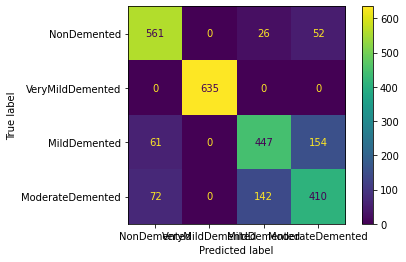

In [ ]:
plot_confusion_matrix(model_LR, test_data, test_labels, labels=CLASSES)

In [ ]:
print(classification_report(test_labels, pred_data, labels=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.81      0.88      0.84       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.73      0.68      0.70       662
ModerateDemented       0.67      0.66      0.66       624

        accuracy                           0.80      2560
       macro avg       0.80      0.80      0.80      2560
    weighted avg       0.80      0.80      0.80      2560



### Decision Tree Classifier

In [ ]:
model_DT = DecisionTreeClassifier()

In [ ]:
model_DT.fit(train_data, train_labels)

DecisionTreeClassifier()

In [ ]:
pred_data = model_DT.predict(test_data)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


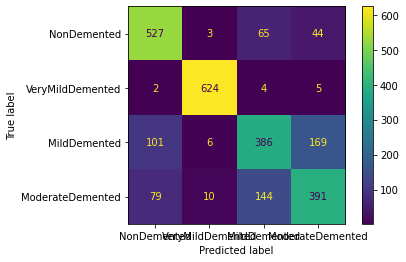

In [ ]:
plot_confusion_matrix(model_DT, test_data, test_labels, labels=CLASSES)

In [ ]:
print(classification_report(test_labels, pred_data, labels=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.74      0.82      0.78       639
VeryMildDemented       0.97      0.98      0.98       635
    MildDemented       0.64      0.58      0.61       662
ModerateDemented       0.64      0.63      0.63       624

        accuracy                           0.75      2560
       macro avg       0.75      0.75      0.75      2560
    weighted avg       0.75      0.75      0.75      2560



### Random Forest Classifier

In [ ]:
model_RF = RandomForestClassifier()

In [ ]:
model_RF.fit(train_data, train_labels)

RandomForestClassifier()

In [ ]:
pred_data = model_RF.predict(test_data)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


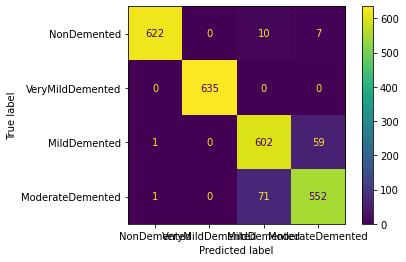

In [ ]:
plot_confusion_matrix(model_RF, test_data, test_labels, labels=CLASSES)

In [ ]:
print(classification_report(test_labels, pred_data, labels=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       1.00      0.97      0.98       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.88      0.91      0.90       662
ModerateDemented       0.89      0.88      0.89       624

        accuracy                           0.94      2560
       macro avg       0.94      0.94      0.94      2560
    weighted avg       0.94      0.94      0.94      2560



### Support Vector Classifier

In [ ]:
model_SVC = SVC()

In [ ]:
model_SVC.fit(train_data, train_labels)

SVC()

In [ ]:
pred_data = model_SVC.predict(test_data)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


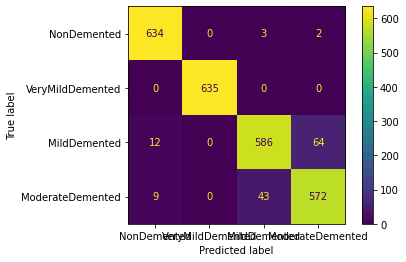

In [ ]:
plot_confusion_matrix(model_SVC, test_data, test_labels, labels=CLASSES)

In [ ]:
print(classification_report(test_labels, pred_data, labels=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.97      0.99      0.98       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.93      0.89      0.91       662
ModerateDemented       0.90      0.92      0.91       624

        accuracy                           0.95      2560
       macro avg       0.95      0.95      0.95      2560
    weighted avg       0.95      0.95      0.95      2560



Thus, our best classifier is SVM with an accuracy of 95%.